## Imports

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data_utils

import skorch
from skorch import NeuralNetRegressor



## Loading in dataframe

In [5]:
data_path = '../processed_data.csv'
data = pd.read_csv(data_path)
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].astype(float) / data['houses']
display(data.head())

energy_min = data['energy(kWh/hh)'].min()
energy_max = data['energy(kWh/hh)'].max()

data['energy(kWh/hh)'] = (data['energy(kWh/hh)'].astype(float) - energy_min) / (energy_max - energy_min)
data.info()
data.head()


,index,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
0,0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.284500,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.280500,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.153333,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.098000,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.110286,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           39727 non-null  int64  
 1   timestamp       39727 non-null  object 
 2   year            39727 non-null  int64  
 3   month           39727 non-null  int64  
 4   day             39727 non-null  int64  
 5   hour            39727 non-null  int64  
 6   minute          39727 non-null  int64  
 7   day_of_week     39727 non-null  int64  
 8   weekend         39727 non-null  int64  
 9   holiday         39727 non-null  int64  
 10  energy(kWh/hh)  39727 non-null  float64
 11  houses          39727 non-null  int64  
 12  visibility      39727 non-null  float64
 13  temperature     39727 non-null  float64
 14  dewPoint        39727 non-null  float64
 15  pressure        39727 non-null  float64
 16  windSpeed       39727 non-null  float64
 17  precipType      39727 non-null 

,index,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
0,0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.496932,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.486617,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.158681,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.015988,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.047670,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


## Adding Input and target columns

In [6]:

data_mod = data.drop(['index','timestamp', 'houses', 'pressure', 'dewPoint'], axis=1)
timesteps = 49


for i in range(1, timesteps):
    data_mod['energy(kWh/hh)_prev_' + str(i*.5)] = data_mod['energy(kWh/hh)'].shift(i)
    data_mod['energy(kWh/hh)_next_' + str(i*.5)] = data_mod['energy(kWh/hh)'].shift(-i)



columns = data_mod.columns.to_list()
columns.remove('energy(kWh/hh)')
prev_column = [col for col in columns if 'prev' in col]
next_column = [col for col in columns if 'next' in col]
columns = columns[:13] + ['energy(kWh/hh)'] + prev_column + next_column
print(columns)

data_mod = data_mod[columns]

['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'weekend', 'holiday', 'visibility', 'temperature', 'windSpeed', 'precipType', 'humidity', 'energy(kWh/hh)', 'energy(kWh/hh)_prev_0.5', 'energy(kWh/hh)_prev_1.0', 'energy(kWh/hh)_prev_1.5', 'energy(kWh/hh)_prev_2.0', 'energy(kWh/hh)_prev_2.5', 'energy(kWh/hh)_prev_3.0', 'energy(kWh/hh)_prev_3.5', 'energy(kWh/hh)_prev_4.0', 'energy(kWh/hh)_prev_4.5', 'energy(kWh/hh)_prev_5.0', 'energy(kWh/hh)_prev_5.5', 'energy(kWh/hh)_prev_6.0', 'energy(kWh/hh)_prev_6.5', 'energy(kWh/hh)_prev_7.0', 'energy(kWh/hh)_prev_7.5', 'energy(kWh/hh)_prev_8.0', 'energy(kWh/hh)_prev_8.5', 'energy(kWh/hh)_prev_9.0', 'energy(kWh/hh)_prev_9.5', 'energy(kWh/hh)_prev_10.0', 'energy(kWh/hh)_prev_10.5', 'energy(kWh/hh)_prev_11.0', 'energy(kWh/hh)_prev_11.5', 'energy(kWh/hh)_prev_12.0', 'energy(kWh/hh)_prev_12.5', 'energy(kWh/hh)_prev_13.0', 'energy(kWh/hh)_prev_13.5', 'energy(kWh/hh)_prev_14.0', 'energy(kWh/hh)_prev_14.5', 'energy(kWh/hh)_prev_15.0', 'energy(kWh/h

## Removing Datapoints without previous or next info

In [7]:
# Removing NaN value rows
data_mod_clean = data_mod[data_mod[prev_column[-1]].notna()]
data_mod_clean = data_mod_clean[data_mod_clean[next_column[-1]].notna()]
data_mod_clean = data_mod_clean.reset_index(drop=True)

data_mod_clean.to_csv('../processed_data_train.csv', index=False)

display(data_mod_clean.head())
display(data_mod_clean.tail())

,year,month,day,hour,minute,day_of_week,weekend,holiday,visibility,temperature,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
0,2011,11,24,9,0,3,0,0,9.540000,10.120000,...,0.171747,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080
1,2011,11,24,9,30,3,0,0,9.968507,10.508810,...,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140
2,2011,11,24,10,0,3,0,0,10.590000,10.990000,...,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292
3,2011,11,24,10,30,3,0,0,11.425628,11.649751,...,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292,0.165834
4,2011,11,24,11,0,3,0,0,12.210000,12.290000,...,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292,0.165834,0.131856


,year,month,day,hour,minute,day_of_week,weekend,holiday,visibility,temperature,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
39626,2014,2,26,22,0,2,0,0,12.960000,6.240000,...,0.452177,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284
39627,2014,2,26,22,30,2,0,0,12.821424,6.259442,...,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642
39628,2014,2,26,23,0,2,0,0,13.160000,6.270000,...,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828
39629,2014,2,26,23,30,2,0,0,13.183213,6.114206,...,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439
39630,2014,2,27,0,0,3,0,0,12.990000,6.010000,...,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439,0.302225


## Simple Feed Forward Network

In [8]:
class ForecastNetwork(nn.Module):
    def __init__(self, input_time_dim, input_other_dim, output_dim, layers, nodes, activation=nn.ReLU):
        super(ForecastNetwork, self).__init__()
        self.input_time_dim = input_time_dim
        self.input_dim = input_other_dim
        self.output_dim = output_dim
        self.layers = layers
        self.nodes = nodes
        self.conv_channels = 4
        self.kernel_size = 8

        self.conv_dim = int((input_time_dim - 1*(self.kernel_size-1) -1)/1 + 1)

        layers = []

        # Time convolution
        self.unflat = nn.Unflatten(1, (1, self.input_time_dim))
        self.conv1 = nn.Conv1d(1, self.conv_channels, self.kernel_size, bias=False)
        self.flat = nn.Flatten()

        for i in range(self.layers):
            if i == 0:
                layers.append(nn.Linear(self.input_dim + self.conv_dim*self.conv_channels, self.nodes))
                layers.append(activation())
            elif i == self.layers - 1:
                layers.append(nn.Linear(self.nodes, self.output_dim))
            else:
                layers.append(nn.Linear(self.nodes, self.nodes))
                layers.append(activation())

        self.module = nn.Sequential(*layers)

    
    def forward(self, x):
        conv = self.unflat(x[:, self.input_dim:])
        conv = self.conv1(conv)
        conv = self.flat(conv)
        conv = torch.cat((conv, x[:, :self.input_dim]), dim=1)
        out = self.module(conv)
        return out


## Making datasets

In [10]:
input_names = [
    'month', 
    'day', 
    'hour', 
    'minute', 
    'day_of_week', 
    'weekend', 
    'holiday', 
    'visibility', 
    'temperature', 
    'windSpeed', 
    'precipType', 
    'humidity', 
    'energy(kWh/hh)',
] + prev_column

target_names = next_column

data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float()
target_tensor = torch.tensor(targets.values).float()

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.8)], target_tensor[:int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


## Skorch Training

In [ ]:
module = ForecastNetwork(timesteps, input_tensor.shape[1]-timesteps, target_tensor.shape[1], 6, 250)

In [22]:
net = NeuralNetRegressor(
    module,
    max_epochs=100,
    lr=0.00005,
    batch_size=64,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.00001,
    criterion=nn.MSELoss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0008        0.0127  0.7912
      2        0.0008        0.0127  0.7621
      3        0.0008        0.0127  0.7575
      4        0.0008        0.0128  0.7773
      5        0.0008        0.0128  0.7979
      6        0.0008        0.0128  0.7667
      7        0.0008        0.0128  0.7809
      8        0.0008        0.0128  0.8087
      9        0.0008        0.0128  0.7419
     10        0.0008        0.0128  0.7783
     11        0.0008        0.0127  0.7586
     12        0.0008        0.0127  0.7312
     13        0.0008        0.0127  0.7423
     14        0.0008        0.0127  0.7920
     15        0.0008        0.0127  0.8001
     16        0.0008        0.0126  0.7717
     17        0.0008        0.0126  0.7624
     18        0.0008        0.0126  0.7628
     19        0.0008        0.0126  0.7582
     20        0.0008        0.0126  0.7544
     21        0.0008        0.0

## Testing Training

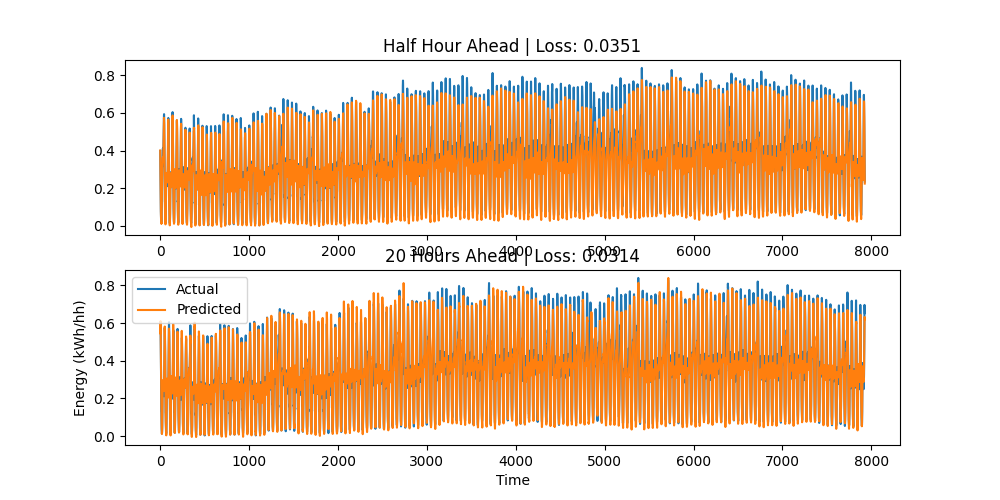

In [23]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = net.module(x_test.float().cuda()).cpu().detach()

half_pred = y_pred[:, 0]

half_loss = loss(y_pred[:, 0], y_test[:, 0]).item()
hour_loss = loss(y_pred[:, 1], y_test[:, 1]).item()
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2]).item()
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

ax[1].plot(y_test[:, 40], label='Actual')
ax[1].plot(y_pred[:, 40], label='Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh/hh)')
ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()

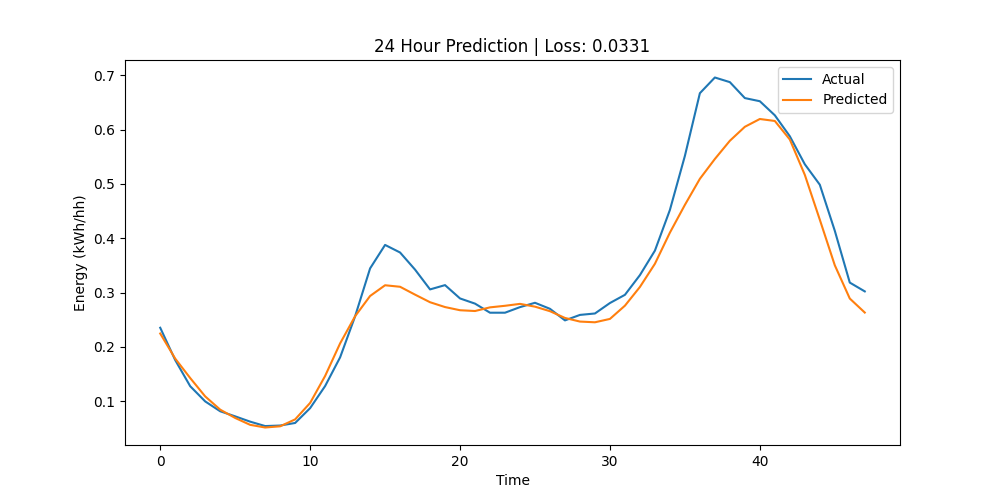

In [24]:
loss = nn.L1Loss()

x_test, y_test = dataset_test[:]

y_pred = net.module(x_test.float().cuda()).cpu().detach().squeeze()

overall_loss = loss(y_pred, y_test).item()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test[-1], label='Actual')
ax.plot(y_pred[-1], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh/hh)')
ax.set_title(f'24 Hour Prediction | Loss: {overall_loss:.4f}')
plt.legend()


In [130]:
class ForecastLSTM(nn.Module):
    def __init__(self, num_classes, hidden_linear_size, input_size, hidden_size, num_layers, seq_length, other_feature_size, device='cuda'):
        super(ForecastLSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.other_feature_size = other_feature_size
        self.device = device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(seq_length + other_feature_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(self.device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(self.device)

        x_other = x[:, :self.other_feature_size, :].squeeze(-1)
        x_lstm = x[:, self.other_feature_size:, :]
        
        h_all, (h_out, c_out) = self.lstm(x_lstm, (h_0, c_0))

        out = self.fc1(h_all).squeeze(-1)  
        out = self.relu1(out)
        
        out = torch.cat((out, x_other), dim=1)
        out = self.fc2(out)
        
        return out

In [114]:
non_energy_columns = [
    'month', 
    'day', 
    'hour', 
    'minute', 
    'day_of_week', 
    'weekend', 
    'holiday', 
    'visibility', 
    'temperature', 
    'windSpeed', 
    'precipType', 
    'humidity'
]

input_energy_columns = [
    'energy(kWh/hh)',
] + prev_column

input_names = non_energy_columns + input_energy_columns

target_names = next_column

data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float().unsqueeze(-1)
target_tensor = torch.tensor(targets.values).float()

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.8)], target_tensor[:int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


In [131]:
module = ForecastLSTM(target_tensor.shape[1], 48, 1, 48, 1, timesteps, len(non_energy_columns)).to('cuda')

test = module(input_tensor[0].unsqueeze(0).cuda())

In [134]:
net = NeuralNetRegressor(
    module,
    max_epochs=100,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.00001,
    criterion=nn.MSELoss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0093        0.0661  3.8460
      2        0.0092        0.0518  3.9513
      3        0.0092        0.0647  3.8682
      4        0.0093        0.0662  3.7899
      5        0.0091        0.0650  3.8714


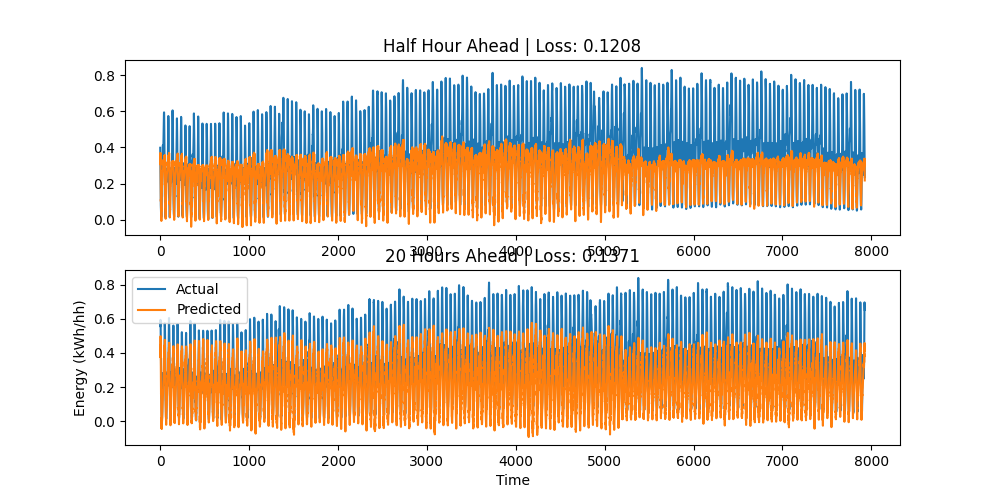

In [133]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = net.module(x_test.float().cuda()).cpu().detach()

half_pred = y_pred[:, 0]

half_loss = loss(y_pred[:, 0], y_test[:, 0]).item()
hour_loss = loss(y_pred[:, 1], y_test[:, 1]).item()
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2]).item()
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

ax[1].plot(y_test[:, 40], label='Actual')
ax[1].plot(y_pred[:, 40], label='Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh/hh)')
ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()